In [ ]:
#!pip3 install torch==1.6.0

# Human iris center calculation
Eyes are considered to be the most salient and stable feature in the computer vision community. Automatic
extraction of eyes plays an important role in many real-world applications such as gaze tracking, face alignment, driver drowsiness detection, face recognition, and human–computer interaction, etc. Several factors
that make challenging to detect and track eyes are head poses, lighting conditions, shape and color of eyes,
iris movement, imagining quality and conditions, etc. A lot of works have been performed to solve the above
problems but still, it remains an open area of research in the computer vision community.
In this task we are going to implement CNN for calculating human iris center. 


## 1. Preprocessing and downloading dataset

### Downloading dataset
Connect Google.Drive to Google.Colab and downloading dataset for EDA

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/ML_assignment_2/gi4e_database.zip', 'r') as zip:
  A = zip.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_file = ZipFile('/content/drive/MyDrive/ML_assignment_2/gi4e_database.zip')

### Import libraries


In [ ]:
import numpy as np
import pandas as pd

import os

from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms

import torch.nn.functional as F




import cv2

#import matplotlib as plt

In [ ]:
from google.colab.patches import cv2_imshow

### Colouring images to grey

Creating a list of images

In [ ]:
images = []

for f in df_file.namelist():
  if f[-3:]=='png':
    image = cv2.imread(f)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))


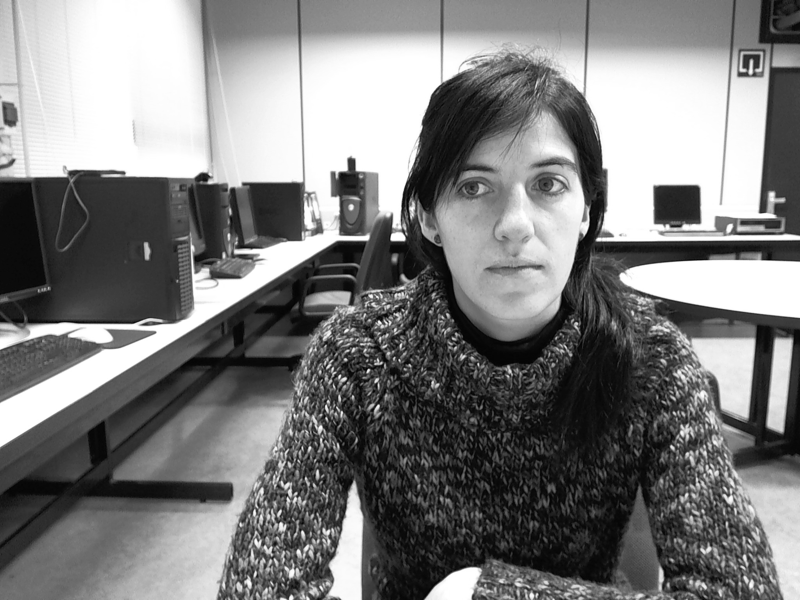

In [ ]:
cv2_imshow(images[40])

### Visualizing
Visuaizing one image, draw eye corners and iris centers on it

In [ ]:
def print_img(number,images = images, file_path='labels/image_labels.txt'):
  ''' This program draw picture with marked eye corners and irises '''
  with open(file_path, 'r') as t:
    s = list(t)
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = [int(float(i)) for i in s[number].split()[1:]]

  image = images[number].copy()
  image_new = cv2.circle(image, (x1,y1), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x2,y2), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x3,y3), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x4,y4), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x5,y5), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x5,y5), radius=2, color=(255, 0, 0), thickness=-1)
  image_new = cv2.circle(image, (x6,y6), radius=2, color=(255, 0, 0), thickness=-1)
  cv2_imshow(image_new)



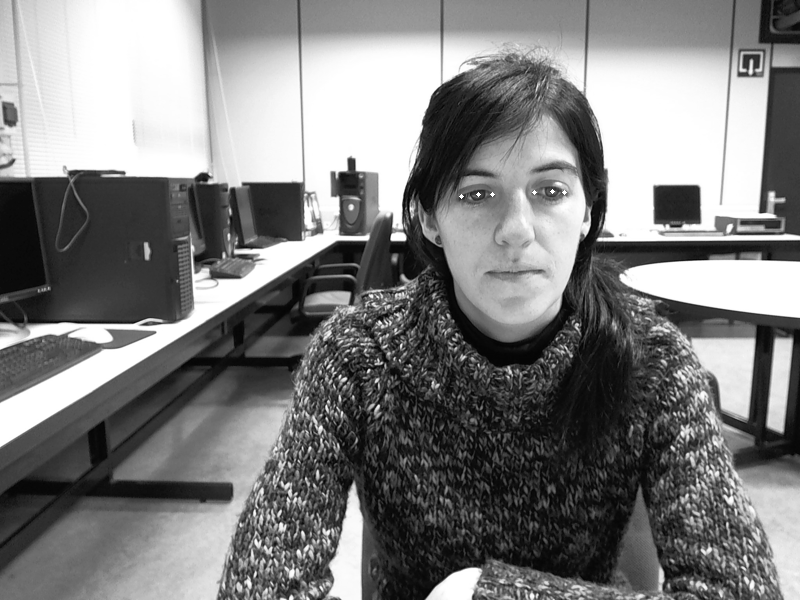

In [ ]:
print_img(45)

### Normilizing Images


In [ ]:
images_normilized = [i/255 for i in images]

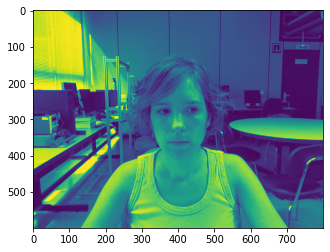

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images_normilized[20])

### Creating a dataset
#### Cropping images, resizing them and creating images with iris
Cropping eye regions (and resize if needed) to be (48x48) image with the help of eye corners. 
Formula for rectangle:
$I = \{(x, y)|l_x − \dfrac{d_x}{2} ≤ x ≤ r_x + \dfrac{d_x}{2} , l_y + \dfrac{d_y}{2} − d_x ≤ y ≤ r_y − \dfrac{d_y}{2}+d_x\} $

for $d_x = r_x − l_x , d_y = r_y − l_y$

$(l_x,l_y),(r_x,r_y)$ - coordinates of eye corners

Also, I've created a target images and do the same transformations as for train images (cropping and reshaping).
Target images - are black with marked white iris.

In [ ]:
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

#from PIL import Image
#Collect all coordinates in list
def get_rectangle(x1,y1,x3,y3):
  '''Calculating boundaries for cropping as in equation'''
  lx = x3
  ly=y3
  rx=x1
  ry=y1
  dx=rx-lx
  dy=ry-ly
  x=[round(lx-dx/2),round(rx+dx/2)]
  y=[round(ly+dy/2-dx),round(ry-dy/2+dx)]
  #Important: y[0]<y[1],x[0]<x[1]
  return x,y 

#Creating target images
iris_only = []
coordinates = []
#reading coordinates from txt-file
with open('labels/image_labels.txt', 'r') as t:
  s = list(t)
  for string in s:
    coordinates.append([int(float(i)) for i in string.split()[1:]]) 

images_cropped = []

#crop area from image and resize

for i in range(len(images_normilized)):
  x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = coordinates[i]

  #for left_eye
  x,y=get_rectangle(x4, y4, x6, y6 ) #get boundaries for cropping
  new_image = images_normilized[i][y[0]:y[1], x[0]:x[1]] 
  iris_new = np.zeros_like(new_image)#create a black image with the same size as cropped image
  #iris_new.fill(1)
  iris_new[y5-y[0],x5-x[0]] = 1 #colour iris on the black image
  images_cropped.append(resize(new_image, (48,48), anti_aliasing=True)) #add resized image to the vector
  iris_only.append(resize(gaussian_filter(iris_new, sigma=1), (48,48), anti_aliasing=True)) #add resized and blured image to the vector

  #the same actions for the right eye
  #for right eye
  x,y = get_rectangle(x1, y1, x3, y3)
  new_image = images_normilized[i][y[0]:y[1], x[0]:x[1]]
  iris_new = np.zeros_like(new_image)
  #iris_new.fill(1)
  iris_new[y2-y[0],x2-x[0]] = 1
  images_cropped.append(resize(new_image, (48,48), anti_aliasing=True)) 
  iris_only.append(resize(gaussian_filter(iris_new, sigma=1), (48,48), anti_aliasing=True))

  

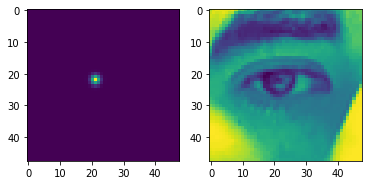

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(iris_only[60])
axes[1].imshow(images_cropped[60])


### Splitting dataset

In [ ]:
X = np.array(images_cropped)
y = np.array(iris_only)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state = 42)

In [ ]:
print(len(X_test))

248


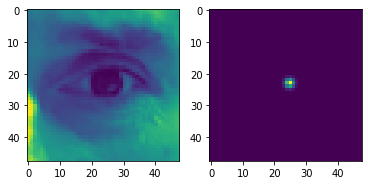

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_test[60])
axes[1].imshow(y_test[60])

In [ ]:
X_test[60][25][24]

0.06200980392156857

## 2. Building a CNN model using PyTorch

In [ ]:
batch_size = 2
test_batch_size = 2

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.Tensor(data)
        self.targets = torch.Tensor(targets)
        self.data = self.data[:,None,:]
        self.targets=self.targets[:,None,:]
        print(self.data.shape,self.targets.shape)
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)


train = MyDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=batch_size)
test = MyDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=batch_size)

torch.Size([2224, 1, 48, 48]) torch.Size([2224, 1, 48, 48])
torch.Size([248, 1, 48, 48]) torch.Size([248, 1, 48, 48])


Convolutional formula:

$\dfrac{n+2p-f}{s}+1=v$

where $n=48,v=48,s=1,p=1 => f = 3$ for the 1 layer

Transpose formula: 

$(n - 1)s - 2p + f$

In [ ]:
class Net(nn.Module):
        
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=1)
        self.transpose1 = nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2)
        self.transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2)
        self.transpose3 = nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1, stride=1)
        self.transpose_base2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=1)
        self.transpose_base1 = nn.ConvTranspose2d(256, 64, kernel_size=4, padding=0, stride=4)
        self.conv2_drop = nn.Dropout2d(p=0.25)

    def forward(self, x):

        x = self.conv1(x) 
        x = F.tanh(x)
        x1 = x 
        x = self.conv2(x) 
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2) 
        x = F.tanh(x)
        x = self.conv3(x) 
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2) 
        x = F.tanh(x) 
        y = x
        x = self.transpose_base1(x) 
        x = self.conv2_drop(x)
        x = torch.cat([x, x1], axis=1) 
        x = F.tanh(x)
        x = self.transpose_base2(x)
        x = self.conv2_drop(x)
        x = F.tanh(x)
        x = self.transpose3(x)
        x = F.sigmoid(x)
        y = self.transpose1(y) 
        y = self.conv2_drop(y)
        y = F.tanh(y)
        y = self.transpose2(y)
        y = self.conv2_drop(y)
        y = F.tanh(y)
        y = self.transpose3(y) 
        y = self.conv2_drop(y)
        y = F.sigmoid(y)
        return x,y

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

### Finding the best optimizer and loss

In [ ]:
# epochs = 1
# lr = 0.00005
# momentum = 0.005
# log_interval = 700

# # training CNN model
# model = model_cnn
# #optimizer = torch.optim.RMSprop(model.parameters(),alpha=0.9, lr=lr, momentum=momentum, weight_decay=0.0001)
# outputs = []
# optimizers = [torch.optim.SGD, torch.optim.Adamax, torch.optim.Adam, torch.optim.RMSprop]
# criterions =[nn.MSELoss(),nn.L1Loss()]

# for optimizer in optimizers:
#   optimizer = optimizer(model.parameters(),lr= lr, weight_decay = 1e-6)
#   for criterion in criterions:
#     #criterion = nn.MSELoss()    
#     for epoch in range(epochs):
#       for img, label in train_loader:
#         img, label = img.to(device), label.to(device)
#         iris,pict  = model(img)
#         #loss = criterion(recon[:,1:2,],img)
#         x=torch.argmax(label[:,:]).item()//48
#         y=torch.argmax(label[:,:]).item()%48
#         loss = criterion(pict[:,:,x-10:x+10,y-10:y+10], img[:,:,x-10:x+10,y-10:y+10]) 
        
#         loss2 = criterion(label[:,:,x-10:x+10,y-10:y+10], iris[:,:,x-10:x+10,y-10:y+10])
#         loss+=loss2
#         #loss += loss2
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#       print("Optimizer: ", optimizer, " Loss: ", criterion)
#       print(f"Epoch :{epoch+1}, Loss : {loss.item():.5f}")
#       outputs.append((img,pict,iris, label))

#### Output of previous cell
Optimizer:  SGD  Loss:  MSELoss()
 

Loss : 0.04708

Optimizer:  SGD  Loss:  L1Loss()

Loss : 0.20489


Optimizer:  Adamax Loss:  MSELoss()

Loss : 0.00550


Optimizer:  Adamax Loss:  L1Loss()

Loss : 0.06032


Optimizer:  Adam   Loss:  MSELoss()

Loss : 0.01302

Optimizer:  Adam  Loss:  L1Loss()

 Loss : 0.05652

Optimizer:  RMSprop   MSELoss()

 Loss : 0.00370
 
Optimizer:  RMSprop Loss:  L1Loss()

Loss : 0.11635

#### Result:
This experiment has shown that MSE worked better. The best optimizers: Adamax, RMSprop and SGD

In [ ]:
# epochs = 10
# lr = 0.00005
# momentum = 0.005
# log_interval = 700

# # training CNN model
# model = model_cnn
# #optimizer = torch.optim.RMSprop(model.parameters(),alpha=0.9, lr=lr, momentum=momentum, weight_decay=0.0001)
# outputs = []
# optimizers = [torch.optim.SGD, torch.optim.Adamax, torch.optim.RMSprop]

# for optimizer in optimizers:
#   optimizer = optimizer(model.parameters(),lr= lr, weight_decay = 1e-6)
#   criterion = nn.MSELoss()    
#   for epoch in range(epochs):
#     for img, label in train_loader:
#       img, label = img.to(device), label.to(device)
#       iris,pict  = model(img)
#       #loss = criterion(recon[:,1:2,],img)
#       x=torch.argmax(label[:,:]).item()//48
#       y=torch.argmax(label[:,:]).item()%48
#       loss = criterion(pict[:,:,x-10:x+10,y-10:y+10], img[:,:,x-10:x+10,y-10:y+10]) 
      
#       loss2 = criterion(label[:,:,x-10:x+10,y-10:y+10], iris[:,:,x-10:x+10,y-10:y+10])
#       loss+=loss2
#       #loss += loss2
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#     print("Optimizer: ", type(optimizer).__name__)
#     print(f"Epoch :{epoch+1}, Loss : {loss.item():.5f}")
#     outputs.append((img,pict,iris, label))

Results of all optimizers almost same. We will use Adamax optimizer

Output of previous cell:  

Optimizer:  SGD

Epoch :8, Loss : 0.00303

Optimizer:  Adamax

Epoch :10, Loss : 0.00293


Optimizer:  RMSprop


Epoch :10, Loss : 0.00189

In [ ]:
epochs = 10
lr = 0.00005
momentum = 0.005
log_interval = 700

# training CNN model
model = model_cnn
#optimizer = torch.optim.RMSprop(model.parameters(),alpha=0.9, lr=lr, momentum=momentum, weight_decay=0.0001)
outputs = []
optimizer = torch.optim.Adamax(model.parameters(),lr= lr, weight_decay = 1e-6)
criterion = nn.MSELoss()    
for epoch in range(epochs):
  for img, label in train_loader:
    img, label = img.to(device), label.to(device)
    iris,pict  = model(img)
    #loss = criterion(recon[:,1:2,],img)
    x=torch.argmax(label[:,:]).item()//48
    y=torch.argmax(label[:,:]).item()%48
    loss = criterion(pict[:,:,x-10:x+10,y-10:y+10], img[:,:,x-10:x+10,y-10:y+10]) 
    
    loss2 = criterion(label[:,:,x-10:x+10,y-10:y+10], iris[:,:,x-10:x+10,y-10:y+10])
    loss+=loss2
    #loss += loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #print("Optimizer: ", type(optimizer).__name__)
  print(f"Epoch :{epoch+1}, Loss : {loss.item():.5f}")
  outputs.append((img,pict,iris, label))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :1, Loss : 0.02119
Epoch :2, Loss : 0.01696
Epoch :3, Loss : 0.02565
Epoch :4, Loss : 0.02470
Epoch :5, Loss : 0.00474
Epoch :6, Loss : 0.02492
Epoch :7, Loss : 0.01551
Epoch :8, Loss : 0.02454
Epoch :9, Loss : 0.00292
Epoch :10, Loss : 0.01552


### Predicting for test images

In [ ]:
outputs_test=[]
for epoch in range(2):
  for img, label in test_loader:
    img, label = img.to(device), label.to(device)
    iris, pict  = model(img)
    #loss = criterion(recon[:,1:2,],img)
    x=torch.argmax(label[:,:]).item()//48
    y=torch.argmax(label[:,:]).item()%48
    loss = criterion(pict[:,:,x-10:x+10,y-10:y+10], img[:,:,x-10:x+10,y-10:y+10]) 
    
    loss2 = criterion(label[:,:,x-10:x+10,y-10:y+10], iris[:,:,x-10:x+10,y-10:y+10])
    loss+=loss2
    #loss += loss2
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    print(f"Epoch :{epoch+1}, Loss : {loss.item():.5f}")
    loss = 0
    outputs_test.append((img,pict,iris, label))

### Drawing pictures
Now we will draw the pictures with detected irises

#### Train pictures

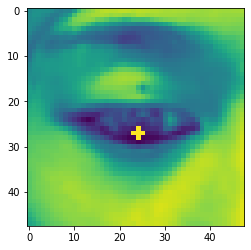

In [ ]:
def bright(x):
  labels = [] #it containes coordinates of ddetected irises
  maximum = -1000000000
  max_idx_j = 0
  max_idx_k = 0
  for j in range(2, 46):
      for k in range(2, 46): 
          if x[j][k] > maximum:
              maximum = x[j][k]
              max_j = j
              max_k = k
  x[max_j][max_k]=1
  labels.append([max_j, max_k])
  return x              

# creating a vectors of iris images and eye images

images = []
res = []
for output in outputs:
  images.append(output[0][0][0].cpu().detach().numpy())
  res.append(output[2][0][0].cpu().detach().numpy())

for r in res:
  r = bright(r)

def print_eye(image, coords):
  ''' This program draw picture of eye with iris ''' 
  image = image.copy()
  y, x = coords[1],coords[0]
 
  image[x][y]=1
  image[x][y+1]=1
  image[x][y-1]=1
  image[x-1][y]=1
  image[x+1][y]=1
  return image

plt.imshow(print_eye(images[9],labels[9]))

#### Test images

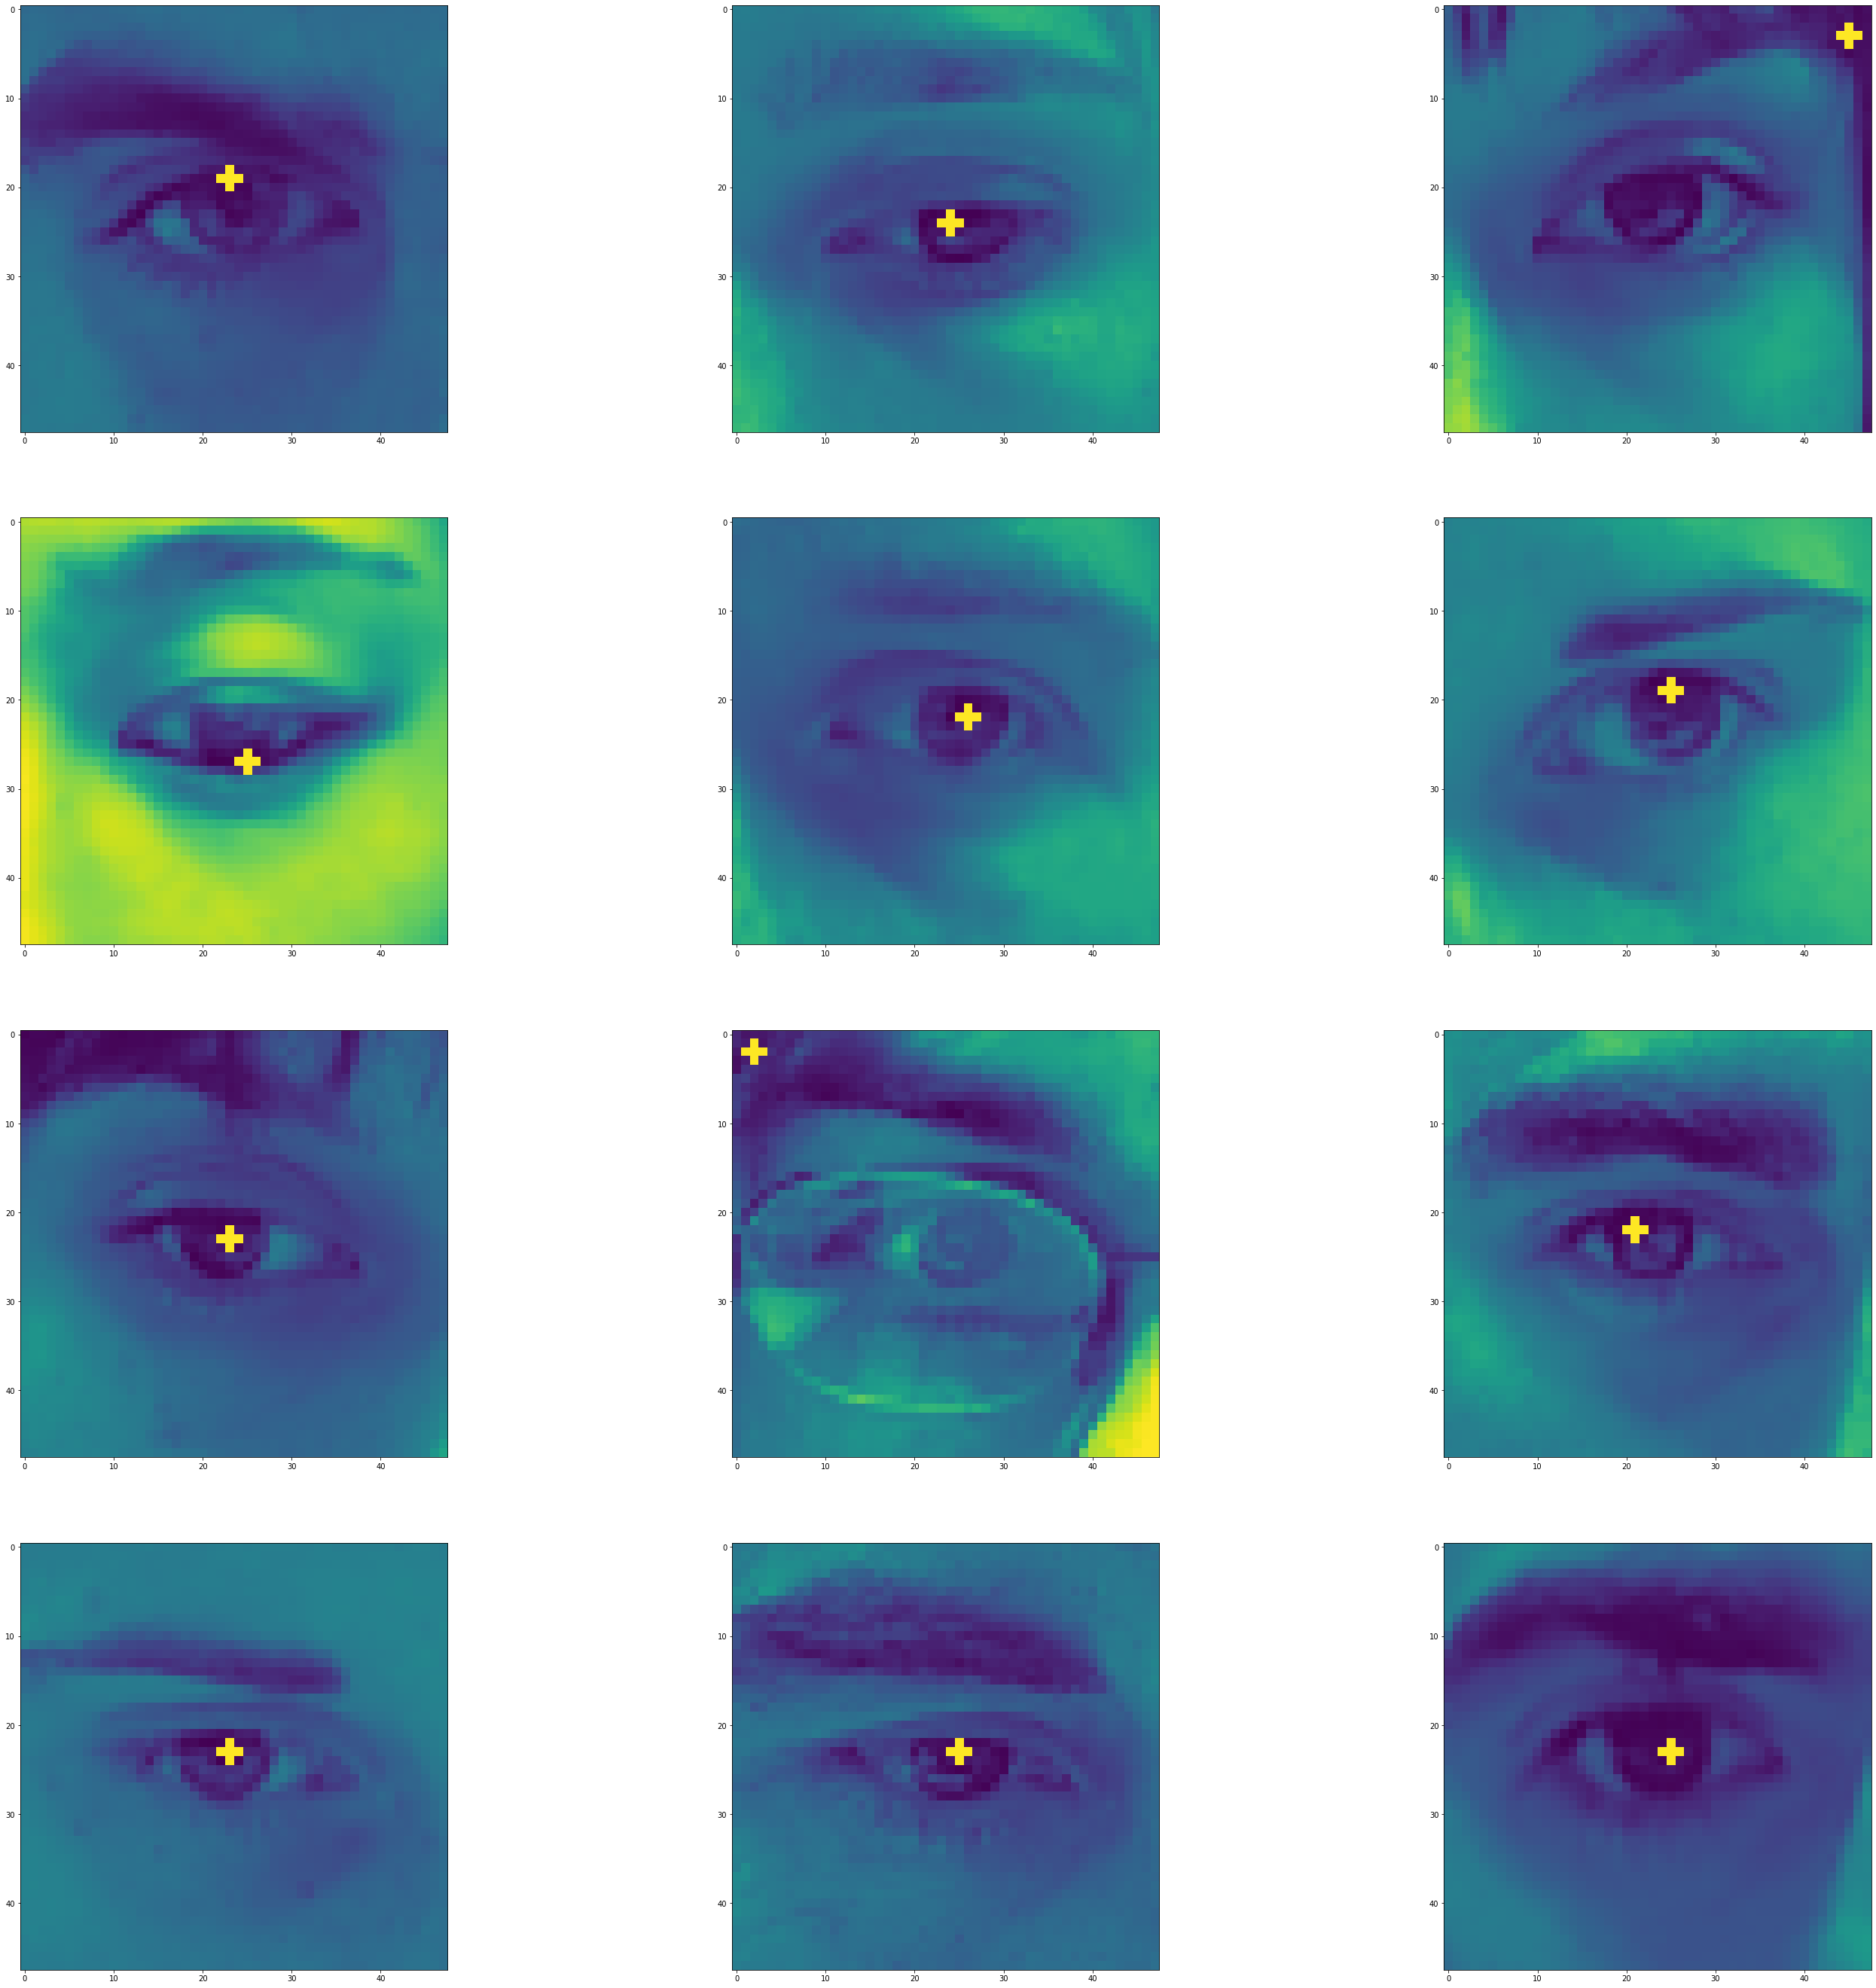

In [ ]:
labels = [] #it containes coordinates of detected irises

def bright(x):
  maximum = -1
  max_idx_j = 0
  max_idx_k = 0
  for j in range(2, 46):
      for k in range(2, 46): 
          if x[j][k] > maximum:
              maximum = x[j][k]
              max_j = j
              max_k = k
  x[max_j][max_k]=1
  labels.append([max_j, max_k])
  return x              

# creating a vectors of iris images and eye images

images = []
res = []
for output in outputs_test:
  images.append(output[0][0][0].cpu().detach().numpy())
  res.append(output[2][0][0].cpu().detach().numpy())


for r in res:
  r = bright(r)

def print_eye(image, coords):
  ''' This program draw picture of eye with iris ''' 
  image = image.copy()
  y, x = coords[1],coords[0]
 
  image[x][y]=1
  image[x][y+1]=1
  image[x][y-1]=1
  image[x-1][y]=1
  image[x+1][y]=1
  return image

#plt.imshow(print_eye(images[9],labels[9]))

fig=plt.figure(figsize=(48, 48))
for i in range(10,22):
  fig.add_subplot(4,3,i-10+1)
  plt.imshow(print_eye(images[i],labels[i]))
plt.show()

### Results

Model works quite good, but there are some problems with people in glasses (as we can see from the test pictures).

# Network Intrusions clustering

Anomalies, also referred to as outliers, are defined as a set of patterns which significantly deviate from the
normal or expected pattern. In our digital age, anomalies are an integral part of many applications including
cyber security , manufacturing, fraud detection, health-care systems and numerous other fields. For instance,
in cyber security, intrusion detection system can identify an anomalous pattern like unauthorized access to
sensitive information or security violation. One of the major challenges include the scarcity of anomalous
labelled data. Most of the systems do not have or few anomalous patterns and make the learning task
difficult. To solve this situation, unsupervised anomaly detection model has the ability to learn the model
without anomalous data patterns.
There are already high performing proposed solution for anomaly binary classification in the domain of
cyber security. To better design a defence system it is important to identify the types or clusters of the
anomalies. In this task we will be using an unsupervised approach to cluster network intrusions. 

Here we work with unsupervised learning problem, so we will use k-means algorithm with number of clusters equals 6 (*An Analysis of K-means Algorithm Based Network Intrusion Detection System
Yi Yi Aung
, Myat Myat Min*). 

## 1. Preprocessing

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/ML_assignment_2/trainset.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ML_assignment_2/testset.csv')

### Encoding categorical features with LabelEncoder




In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
state=np.unique(list(X_train['state'])+list(X_test['state']))

cat_features = ['proto','service']
for i in cat_features:
  le.fit(X_train[i])

  X_train[i] = le.transform(X_train[i])
  X_test[i] = le.transform(X_test[i])
le.fit(state)
X_train['state'] = le.transform(X_train['state'])
X_test['state'] = le.transform(X_test['state'])

### Scaling.
This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0.
It allows to avoid impact of big numbers in calculating distances.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

## K-means

### PCA
Here we use PCA (2 components) to plot graphs

In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

X_test_pca = pca.transform(X_test)

We use Elbow method to detect the number of clusters

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
wcss = []
for i in range(1,21):
  k_means = KMeans(n_clusters=i, init='k-means++', random_state=42)
  k_means.fit(X_pca)
  wcss.append(k_means.inertia_)


Text(0.5, 1.0, 'K-means clustering')

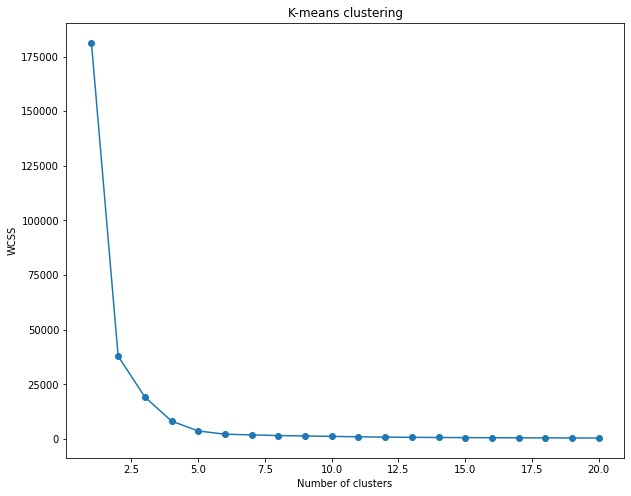

In [ ]:
plt.figure(figsize =(10,8))
plt.plot(range(1,21),wcss,marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("K-means clustering")

The appropriate **k = 6-7**

In [ ]:


kmeans = KMeans(n_clusters=6, random_state=0).fit(X_train)
kmeans.labels_
kmeans_test = kmeans.predict(X_test)



In [ ]:
kmeans_test

array([0, 0, 0, ..., 5, 5, 0], dtype=int32)

## Visualizing data


In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)
cluster_centers = pca.transform(kmeans.cluster_centers_)
X_test_pca = pca.transform(X_test)

In [ ]:

X_pca = pd.DataFrame(X_pca, columns=['1','2'])
X_pca['cluster']=kmeans.labels_
cluster_1=X_pca[X_pca['cluster']==0]
cluster_2=X_pca[X_pca['cluster']==1]
cluster_3=X_pca[X_pca['cluster']==2]
cluster_4=X_pca[X_pca['cluster']==3]
cluster_5=X_pca[X_pca['cluster']==4]
cluster_6=X_pca[X_pca['cluster']==5]
#cluster_7=X_pca[X_pca['cluster']==6]

clusters = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6]

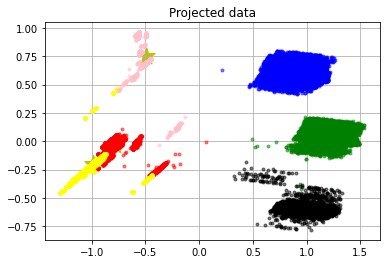

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
colors = ['red','blue','green','yellow','black','pink','orange']
plt.title("Projected data")
for i in range(len(clusters)):
  plt.plot(clusters[i]['1'], clusters[i]['2'], '.', color=colors[i],alpha=0.5)

  #plt.axis([-6, 3, -3, 6])
plt.grid('True')

plt.show()

### Apply clustering to X_test

In [ ]:
X_pca = pd.DataFrame(X_test_pca, columns=['1','2'])
X_pca['cluster']=kmeans_test
cluster_1=X_pca[X_pca['cluster']==0]
cluster_2=X_pca[X_pca['cluster']==1]
cluster_3=X_pca[X_pca['cluster']==2]
cluster_4=X_pca[X_pca['cluster']==3]
cluster_5=X_pca[X_pca['cluster']==4]
cluster_6=X_pca[X_pca['cluster']==5]
#cluster_7=X_pca[X_pca['cluster']==6]

clusters = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6]

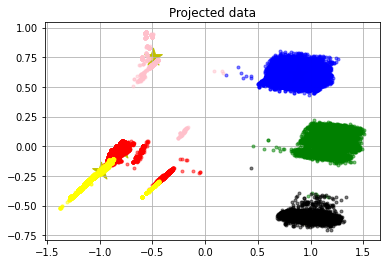

In [ ]:
import matplotlib.pyplot as plt
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='*', c='y', s=350,label='Centroids')
colors = ['red','blue','green','yellow','black','pink','orange']
plt.title("Projected data")
for i in range(len(clusters)):
  plt.plot(clusters[i]['1'], clusters[i]['2'], '.', color=colors[i],alpha=0.5)

  #plt.axis([-6, 3, -3, 6])
plt.grid('True')

plt.show()

## DBScan

In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)
cluster_centers = pca.transform(kmeans.cluster_centers_)
X_test_pca = pca.transform(X_test)

In [ ]:

from sklearn.cluster import DBSCAN
from sklearn import metrics
eps = 0.05
db = DBSCAN(eps=eps, min_samples=300,algorithm='ball_tree', metric='haversine').fit(X_test_pca)
labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, labels), "for eps ",eps)

In [ ]:
X_test_pca = pd.DataFrame(X_test_pca, columns=['1','2'])
X_test_pca['cluster'] = db.labels_
outliers=X_test_pca[X_test_pca['cluster']==-1]

In [ ]:
colors = db.labels_
plt.scatter(X_test_pca['1'], X_test_pca['2'], c = colors)
plt.scatter(outliers['1'], outliers['2'], marker='+', c='b', s=350)


In [ ]:
labels = np.unique(db.labels_)
n_clusters = len(labels) - (1 if -1 in labels else 0)
print('Estimated number of clusters', n_clusters)

In [ ]:
for i in labels:
  print(i,'\t', X_test_pca[X_test_pca['cluster']==i].shape[0])

Output:

Silhouette Coefficient: 0.55 for eps  0.05 (min_samples = 100)

**Silhouette Coefficient: 0.721 for eps  0.05 (min_samples = 300)**

Silhouette Coefficient: 0.714 for eps  0.05 (min_samples = 500)

Silhouette Coefficient: 0.66 for eps  0.1 (min_samples = 100)

Silhouette Coefficient: 0.669 for eps  0.1 (min_samplec = 500)

Silhouette Coefficient: 0.673 for eps  0.05 (min_samples = 1000)



### Conclusion
The number of clusters equals 7, as in result for k-means using elbow method (there was k = 6).
#### DBscan 
Esilon was <=0.1 because of resriction connected RAM. Algorithm worked only with test data because of the same reason.

For the eps = 0.1 and man_samples = 500 (Silhouette Coefficient: 0.669): percentage of outliers is $ \approx $ 0.2%. 

For the eps = 0.05 and man_samples = 500 (Silhouette Coefficient: 0.714): percentage of outliers is $ \approx $ 1.6%.

**The best Silhoette Coefficient = 0.721 was shown in model with eps 0.05 and min_samples = 300: percentage of outliers $ \approx 1\% $**

All this results are appropriate, because the number of intrusions are very small. 

Minuses of this approach: only clustering of test data is available.

In [ ]:
colors = db.labels_
plt.title("Outliers and clusters")
plt.scatter(X_test_pca['1'], X_test_pca['2'], c = colors)
plt.scatter(outliers['1'], outliers['2'], marker='+', c='r', s=350)

# 5 Design Patterns

The impact of design patterns on quality attributes has been extensively evaluated in studies with different
perspectives, objectives, metrics, and quality attributes, leading to contradictive and hard to compare results.
Knowing that a particular module implements a design pattern is a shortcut to design comprehension.
Manually detecting design patterns is a time consuming and challenging task; therefore, researchers have
proposed automatic design patterns detection techniques which include machine learning based approaches.
We will implement a machine learning based approach for detecting design patterns category from open source projects. The dataset is a subset of source code metrics for each an every java project. Each project in the dataset belongs to one of 3 categories: Structural, Behavioral, Creational. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/ML_assignment_2/Dp_data_modified.zip', 'r') as zip:
  A = zip.extractall()

In [ ]:
df_file = ZipFile('/content/drive/MyDrive/ML_assignment_2/Dp_data_modified.zip')

In [ ]:
patterns = {'Abstract_factory':'Creational',
            'Builder':'Creational',
            'Factory':'Creational',
            'Prototype':'Creational',
            'Singleton':'Creational',
            'Adapter':'Structural',
            'Bridge':'Structural',
            'Composite':'Structural',
            'Decorator':'Structural',
            'Facade':'Structural',
            'Flyweight':'Structural',
            'Proxy':'Structural',           
            'Chain_of_responsibility':'Behavioral',
            'Command':'Behavioral',
            'Interpreter':'Behavioral',
            'Iterator':'Behavioral',
            'Mediator':'Behavioral',
            'Memento':'Behavioral',
            'Observer':'Behavioral',
            'State':'Behavioral',
            'Strategy':'Behavioral',
            'Template':'Behavioral',
            'Visitor':'Behavioral'}

In [ ]:
pd.read_csv('Dp_testset/Decorator/ProjectTeam13/ckmetrics/class.csv')

,file,class,type,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,visibleFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,./Decorator/ProjectTeam13/ckmetrics/../entitie...,entities.Post,class,2,9,1,0,18,0.250000,0.583333,9,0,9,0,0,0,9,0,0,0,5,0,0,5,0,0,2,0,0,38,5,0,0,0,0,1,5,8,0,5,0,0,0,0,20,1,0
1,./Decorator/ProjectTeam13/ckmetrics/../entitie...,entities.WebResponse,class,0,4,1,0,0,0.500000,1.000000,4,0,4,0,0,0,4,0,0,0,3,0,0,3,0,0,3,0,0,19,3,0,0,0,0,0,0,3,0,3,0,0,0,0,9,1,0
2,./Decorator/ProjectTeam13/ckmetrics/../entitie...,entities.Admin,class,1,2,2,0,1,0.000000,0.000000,2,0,1,0,0,1,2,0,0,0,1,0,0,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8,1,0
3,./Decorator/ProjectTeam13/ckmetrics/../entitie...,entities.User,class,1,11,1,0,33,0.200000,0.309091,11,0,11,0,0,0,11,0,0,0,5,0,0,5,0,0,0,0,0,43,5,0,0,0,0,3,0,9,0,5,0,0,0,0,19,1,0
4,./Decorator/ProjectTeam13/ckmetrics/../entitie...,entities.Comment,class,1,6,1,0,9,0.400000,0.666667,6,0,6,0,0,0,6,0,0,0,3,0,0,3,0,0,0,0,0,26,4,0,0,0,0,1,2,5,0,3,0,0,0,0,12,1,0
5,./Decorator/ProjectTeam13/ckmetrics/../Main.java,Main,class,1,6,1,7,0,NaN,NaN,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,27,0,1,0,0,1,5,2,2,0,2,2,0,0,0,8,1,0
6,./Decorator/ProjectTeam13/ckmetrics/../Concret...,ConcreteCreators.FeedWebPageCreator,class,6,3,2,6,0,0.000000,0.000000,2,0,1,0,0,1,2,0,0,0,1,0,0,1,0,0,1,0,1,15,2,1,0,0,1,4,2,4,1,4,1,0,0,0,23,1,0
7,./Decorator/ProjectTeam13/ckmetrics/../Concret...,ConcreteCreators.Pages.WebPage,interface,0,1,1,0,0,NaN,NaN,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0
8,./Decorator/ProjectTeam13/ckmetrics/../Concret...,ConcreteCreators.Pages.ProfilePage,class,1,2,1,0,0,1.000000,1.000000,2,0,2,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,9,1,0,0,0,0,0,0,1,0,1,0,0,0,0,9,1,0
9,./Decorator/ProjectTeam13/ckmetrics/../Concret...,ConcreteCreators.Pages.LoginPage,class,1,2,1,0,0,1.000000,1.000000,2,0,2,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,9,1,0,0,0,0,0,0,1,0,1,0,0,0,0,9,1,0


In [ ]:
df_file.namelist()[20:30]

['Dp_testset/Decorator/ProjectTeam12/ckmetrics/method.csv',
 'Dp_testset/Decorator/ProjectTeam12/ckmetrics/variable.csv',
 'Dp_testset/Decorator/ProjectTeam12/ckmetrics/field.csv',
 'Dp_testset/Decorator/ProjectTeam13/',
 'Dp_testset/Decorator/ProjectTeam13/ckmetrics/',
 'Dp_testset/Decorator/ProjectTeam13/ckmetrics/class.csv',
 'Dp_testset/Decorator/ProjectTeam13/ckmetrics/method.csv',
 'Dp_testset/Decorator/ProjectTeam13/ckmetrics/variable.csv',
 'Dp_testset/Decorator/ProjectTeam13/ckmetrics/field.csv',
 'Dp_testset/Decorator/test_project_0/']

Creating of lists which contain paths to test and train files

In [ ]:
train = []
test = []
l = []
for f in df_file.namelist(): 
  i = f.split('/')
  if i[-1] == 'class.csv':
    if i[0] == "Dp_testset":
      test.append(f)
    if i[0]=="Dp_trainset":
      train.append(f)
    #l.append(i[1])

In [ ]:
len(test) 

114

### Processing Data

For each 'class.csv' file in calculating mean of its columns and creating dataset with mean values for each project.

In [ ]:
from sklearn import preprocessing
def process(train):
  """This function takes as input list of pathes to the files, process it, calculates means of columns and creates new DataFrame with info about each file"""
  le = preprocessing.LabelEncoder()
  train_df=pd.DataFrame()

  for f in train:
    tmp_df = pd.read_csv(f)
    if tmp_df.shape[0]!=0 and tmp_df.shape[1]!=0:
      

      #Delete columns 'class','file'
      del tmp_df['file']
      del tmp_df['class']
      del tmp_df['type']

      #Imputes NaN
      tmp_df = tmp_df.fillna(0)


      #calculating mean of all columns
      tmp_df = pd.DataFrame(tmp_df.mean()).T

      #define target for each project
      tmp_df['target']=np.full(1, patterns[f.split('/')[1]])
      
      #append new string to dataset
      train_df = pd.concat([train_df, tmp_df],ignore_index=True)
  return train_df


In [ ]:
train_df = process(train)
test_df = process(test)


In [ ]:
y_train=train_df['target']
X_train = train_df.drop('target',axis=1)

y_test=test_df['target']
X_test = test_df.drop('target',axis=1)

### Scaling data


In [ ]:
from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(X_train)

X_train = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test),columns = X_test.columns)


In [ ]:
X_train

,cbo,wmc,dit,rfc,lcom,tcc,lcc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,totalFieldsQty,staticFieldsQty,publicFieldsQty,privateFieldsQty,protectedFieldsQty,defaultFieldsQty,visibleFieldsQty,finalFieldsQty,synchronizedFieldsQty,nosi,loc,returnQty,loopQty,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,0.318182,0.226164,0.389610,0.246640,0.040191,0.187879,0.281818,0.318182,0.072727,0.185950,0.138528,0.151515,0.161616,0.284585,0.000000,0.0,0.0,0.363636,0.10000,0.000000,0.393939,0.000000,0.000000,0.000000,0.0,0.068912,0.208786,0.069264,0.063636,0.042424,0.000000,0.000000,0.007992,0.075758,0.095371,0.022727,0.090319,0.090909,0.484848,0.0,0.000000,0.550609,0.001086,0.0
1,0.269231,0.158537,0.428571,0.197101,0.017544,0.055556,0.055556,0.250000,0.066667,0.272727,0.000000,0.000000,0.000000,0.260870,0.166667,0.0,0.0,0.153846,0.00000,0.000000,0.111111,0.051282,0.000000,0.000000,0.0,0.094754,0.145933,0.031746,0.116667,0.000000,0.000000,0.000000,0.024419,0.039683,0.055215,0.125000,0.038961,0.055556,0.000000,0.0,0.000000,0.171821,0.292875,0.0
2,0.269231,0.178862,0.380952,0.146860,0.016374,0.031746,0.031746,0.250000,0.044444,0.272727,0.000000,0.000000,0.000000,0.260870,0.000000,0.0,0.0,0.102564,0.00000,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.063169,0.145136,0.042328,0.155556,0.051852,0.000000,0.171429,0.022791,0.105820,0.067485,0.222222,0.071429,0.074074,0.000000,0.0,0.000000,0.306415,0.195819,0.0
3,0.224359,0.203252,0.349206,0.328502,0.016374,0.083333,0.150794,0.256944,0.133333,0.272727,0.021164,0.000000,0.000000,0.260870,0.000000,0.0,0.0,0.205128,0.00000,0.000000,0.148148,0.068376,0.000000,0.025253,0.0,0.200036,0.221691,0.063492,0.077778,0.000000,0.021739,0.000000,0.065118,0.119048,0.131902,0.083333,0.136364,0.185185,0.000000,0.0,0.888889,0.343643,0.195819,0.0
4,0.188462,0.146341,0.285714,0.083478,0.012632,0.200000,0.200000,0.225000,0.080000,0.245455,0.000000,0.000000,0.000000,0.234783,0.000000,0.0,0.0,0.061538,0.00000,0.000000,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.106220,0.000000,0.140000,0.000000,0.000000,0.000000,0.005861,0.000000,0.022086,0.000000,0.023377,0.066667,0.000000,0.0,0.000000,0.159794,0.001706,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0.246795,0.109756,0.333333,0.104348,0.010526,0.166667,0.166667,0.187500,0.066667,0.159091,0.063492,0.000000,0.074074,0.173913,0.000000,0.0,0.0,0.051282,0.00000,0.000000,0.000000,0.051282,0.000000,0.000000,0.0,0.000000,0.112440,0.000000,0.000000,0.000000,0.000000,0.000000,0.029303,0.000000,0.036810,0.000000,0.038961,0.000000,0.000000,0.0,0.000000,0.141753,0.001706,0.0
365,0.206410,0.141463,0.609524,0.078841,0.023860,0.080000,0.080000,0.241667,0.026667,0.236364,0.000000,0.000000,0.088889,0.252174,0.066667,0.0,0.0,0.061538,0.00000,0.000000,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.116746,0.177778,0.000000,0.000000,0.000000,0.000000,0.015628,0.087302,0.025767,0.116667,0.027273,0.000000,0.000000,0.0,0.000000,0.192440,0.234641,0.0
366,0.307692,0.138502,0.918367,0.069565,0.015789,0.047619,0.047619,0.236607,0.014286,0.258117,0.000000,0.000000,0.000000,0.246894,0.000000,0.0,0.0,0.065934,0.00000,0.116460,0.000000,0.000000,0.017857,0.000000,0.0,0.000000,0.143028,0.183673,0.000000,0.000000,0.000000,0.073469,0.042908,0.089286,0.098598,0.348214,0.018785,0.000000,0.000000,0.0,0.000000,0.231959,0.376066,0.0
367,0.201923,0.195122,0.285714,0.185507,0.007018,0.400000,0.400000,0.270833,0.066667,0.272727,0.000000,0.000000,0.074074,0.282609,0.000000,0.0,0.0,0.256410,0.00000,0.000000,0.277778,0.000000,0.000000,0.000000,0.0,0.000000,0.188995,0

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_test_pred=clf.predict(X_test)


In [ ]:
from sklearn import metrics



# caclulate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
#print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
#print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.336283185840708


### Tuning parameters of model

### Random Forest

To find the best parameters for the model we use GridSearch algorithm.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[5,10,25,50,75],'max_features':[4,7,10,15,20,30,40],'min_samples_split':[2,4,6,8,10,12,16,18,20],}
clf = RandomForestClassifier(random_state=1)
crv = GridSearchCV(clf,params,scoring = ('accuracy'),refit=True).fit(X_train,y_train)


In [ ]:

result = crv.best_estimator_

In [ ]:
y_test_pred=result.predict(X_train)
print('Training accuracy = {}'.format(metrics.accuracy_score(y_train, y_test_pred)))

Training accuracy = 0.967479674796748


In [ ]:
y_test_pred=result.predict(X_test)
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Testing accuracy = 0.504424778761062


In [ ]:
crv.best_params_

{'max_features': 15, 'min_samples_split': 8, 'n_estimators': 50}

Best estimator is:
{'max_features': 15, 'min_samples_split': 8, 'n_estimators': 50}

Testing accuracy after GridSearch is $\approx $ 0.5

It can be result of bad data processing (maybe change average of class to the sum of all strings)

### ADAboost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[5,10,25,50,75]}

clf = AdaBoostClassifier(n_estimators=100)

crv = GridSearchCV(clf,params,scoring = ('accuracy'),refit=True).fit(X_train,y_train)




In [ ]:

result = crv.best_estimator_

In [ ]:
y_test_pred=result.predict(X_train)
print('Training accuracy = {}'.format(metrics.accuracy_score(y_train, y_test_pred)))

Training accuracy = 0.8753387533875339


In [ ]:
y_test_pred=result.predict(X_test)
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Testing accuracy = 0.5309734513274337


In [ ]:
crv.best_params_


{'n_estimators': 75}

The best accuracy of ADAboost 0.53 with n_estimators = 75

### GradientBoosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

params = {'n_estimators':[5,10,25,50,75],'min_impurity_decrease':[0,0.05,0.1],'max_features':[4,7,10,15,20,30,40]}


crv = GridSearchCV(clf,params,scoring = ('accuracy'),refit=True).fit(X_train,y_train)

In [ ]:
result = crv.best_estimator_

In [ ]:
y_test_pred=result.predict(X_train)
print('Training accuracy = {}'.format(metrics.accuracy_score(y_train, y_test_pred)))

Training accuracy = 0.8157181571815718


In [ ]:
y_test_pred=result.predict(X_test)
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Testing accuracy = 0.46017699115044247


In [ ]:

crv.best_params_

{'max_features': 30, 'min_impurity_decrease': 0.1, 'n_estimators': 10}

Testing accuracy = 0.46017699115044247
with best parameters
{'max_features': 30, 'min_impurity_decrease': 0.1, 'n_estimators': 10}

### Coclusion
The best model for this task is ADAboost classifier, but its score is very small $\approx $ 53%.
So it might be better to choose another approach to preprocess the data.